In [51]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from climada.entity import Exposures
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone

from climada.engine import ImpactCalc

from climada.util.api_client import Client
import climada.util.yearsets as yearsets


## Exposure object


In [3]:
# Read the Excel file into a pandas DataFrame
file_name = 'Data/Company data/Company examples & locations.xlsx'
exp_df = pd.read_excel(file_name, usecols="A:I", sheet_name = 'Property values')  #Read only columns A to H  
# Remove the rows with no location
exp_df = exp_df[exp_df['Latitude'].notna()]
# Rename the columns using a dictionary
exp_df = exp_df.rename(columns={"Latitude": "latitude", "Longitude": "longitude", "Value (US$ billion)": "value"})

# Download the fincial data
fin_data_df = pd.read_excel(file_name, sheet_name = 'Financial data')  #Read only columns A to H  

In [4]:
# Map the impact function to the exposures assets 

## countries by region:
region_ids_cal = {'NA1': ['AIA', 'ATG', 'ARG', 'ABW', 'BHS', 'BRB', 'BLZ', 
                          'BMU', 'BOL', 'CPV', 'CYM', 'CHL', 'COL', 'CRI', 
                          'CUB', 'DMA', 'DOM', 'ECU', 'SLV', 'FLK', 'GUF', 
                          'GRD', 'GLP', 'GTM', 'GUY', 'HTI', 'HND', 'JAM', 
                          'MTQ', 'MEX', 'MSR', 'NIC', 'PAN', 'PRY', 'PER', 
                          'PRI', 'SHN', 'KNA', 'LCA', 'VCT', 'SXM', 'SUR', 
                          'TTO', 'TCA', 'URY', 'VEN', 'VGB', 'VIR'], \
                  'NA2': ['CAN', 'USA'], \
                  'NI': ['AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'DJI', 
                         'ERI', 'ETH', 'GEO', 'IND', 'IRN', 'IRQ', 'ISR', 
                         'JOR', 'KAZ', 'KWT', 'KGZ', 'LBN', 'MDV', 'MNG', 
                         'MMR', 'NPL', 'OMN', 'PAK', 'QAT', 'SAU', 'SOM', 
                         'LKA', 'SYR', 'TJK', 'TKM', 'UGA', 'ARE', 'UZB', 
                         'YEM'], \
                  'OC': ['ASM', 'AUS', 'COK', 'FJI', 'PYF', 'GUM', 'KIR', 
                         'MHL', 'FSM', 'NRU', 'NCL', 'NZL', 'NIU', 'NFK', 
                         'MNP', 'PLW', 'PNG', 'PCN', 'WSM', 'SLB', 'TLS', 
                         'TKL', 'TON', 'TUV', 'VUT', 'WLF'], \
                  'SI': ['COM', 'COD', 'SWZ', 'MDG', 'MWI', 'MLI', 'MUS', 
                         'MOZ', 'ZAF', 'TZA', 'ZWE'], \
                  'WP1': ['KHM', 'IDN', 'LAO', 'MYS', 'THA', 'VNM'], \
                  'WP2': ['PHL'], \
                  'WP3': ['CHN'], \
                  'WP4': ['HKG', 'JPN', 'KOR', 'MAC', 'TWN'], 
                  'ROW': ['ALB', 'DZA', 'AND', 'AGO', 'ATA', 'AUT', 'BLR', 
                          'BEL', 'BEN', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 
                          'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CMR', 'CAF', 
                          'TCD', 'CXR', 'CCK', 'COG', 'HRV', 'CUW', 'CYP', 
                          'CZE', 'CIV', 'DNK', 'EGY', 'GNQ', 'EST', 'FRO', 
                          'FIN', 'FRA', 'ATF', 'GAB', 'GMB', 'DEU', 'GHA', 
                          'GIB', 'GRC', 'GRL', 'GGY', 'GIN', 'GNB', 'HMD', 
                          'VAT', 'HUN', 'ISL', 'IRL', 'IMN', 'ITA', 'JEY', 
                          'KEN', 'PRK', 'XKX', 'LVA', 'LSO', 'LBR', 'LBY', 
                          'LIE', 'LTU', 'LUX', 'MLT', 'MRT', 'MYT', 'MDA', 
                          'MCO', 'MNE', 'MAR', 'NAM', 'NLD', 'NER', 'NGA', 
                          'MKD', 'NOR', 'PSE', 'POL', 'PRT', 'ROU', 'RUS', 
                          'RWA', 'REU', 'BLM', 'MAF', 'SPM', 'SMR', 'STP', 
                          'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SVK', 'SVN', 
                          'SGS', 'SSD', 'ESP', 'SDN', 'SJM', 'SWE', 'CHE', 
                          'TGO', 'TUN', 'TUR', 'UKR', 'GBR', 'UMI', 'ESH', 
                          'ZMB', 'ALA']}

code_regions = {'NA1': 1, 'NA2': 2, 'NI': 3, 'OC': 4, 'SI': 5, 'WP1': 6, \
                    'WP2': 7, 'WP3': 8, 'WP4': 9, 'ROW': 10}

# Make data frame of countries and region ids and impf_TC id
contry_basin_coderegion = {'ISO3':[], 'region_id_cal': [], 'impf_TC': []}

for key, value in region_ids_cal.items():
    contry_basin_coderegion['ISO3'] += value
    contry_basin_coderegion['region_id_cal'] += [key]*len(value)
    contry_basin_coderegion['impf_TC'] += [code_regions[key]]*len(value)

contry_basin_coderegion_df = pd.DataFrame(contry_basin_coderegion)

# Merge the data frames
exp_df = pd.merge(exp_df, contry_basin_coderegion_df, on='ISO3', how='left')

In [5]:
# Create an exposures object
exp_all = Exposures(exp_df)
# Check that the exposure data is valid
exp_all.check()

# Define company identifier string
company_ref = 'Company ID'

# Define time period
time_periods = ['current', 'future']

# Store the current and future exposures in a dictionary
exp_dict = {time_periods[0]: {ind: Exposures(exp_df[exp_df[company_ref].isin([ind])]) for ind in exp_df[company_ref].unique()}, 
            time_periods[1]: {ind: Exposures(exp_df[exp_df[company_ref].isin([ind])]) for ind in exp_df[company_ref].unique()}}

# Scale the exposures with growth rates



In [6]:
# Add the insurance data to the exposures

# Give the coverage limit and deductible for all companies
# coverage_limit should in prct of the asset value in range [50, 100] %%!
# deductible should be in prct of the asset value in range [0, 10] %%!

coverage_limit =  50
deductible = 1

# Compute netto impact on historical hazard set
for time, exp_time_dict in exp_dict.items():
    exp_dict[time] = {}
    for cpny, exp in exp_time_dict.items():
        exp_dict[time][cpny] = exp.copy()
        exp_dict[time][cpny].gdf['deductible'] = exp_dict[time][cpny].gdf.value * deductible / 100
        exp_dict[time][cpny].gdf['cover'] = exp_dict[time][cpny].gdf.value * coverage_limit / 100

## Hazard objects

{'res_arcsec': ['150'], 'event_type': ['synthetic', 'observed'], 'model_name': ['random_walk', 'STORM'], 'spatial_coverage': ['global', 'country', 'genesis_basin', 'basin'], 'climate_scenario': ['rcp26', 'rcp45', 'rcp60', 'None', 'rcp85'], 'ref_year': ['2040', '2060', '2080'], 'country_iso3alpha': ['AFG', 'ARE', 'BGD', 'BHR', 'BRN', 'BTN', 'CHN', 'DJI', 'EGY', 'ERI', 'ETH', 'FSM', 'GUM', 'HKG', 'IDN', 'IND', 'IRN', 'IRQ', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KOR', 'KWT', 'LAO', 'LKA', 'MAC', 'MDV', 'MHL', 'MMR', 'MNG', 'MNP', 'MYS', 'NPL', 'OMN', 'PAK', 'PHL', 'PLW', 'PRK', 'QAT', 'RUS', 'SAU', 'SDN', 'SGP', 'SOM', 'SYR', 'THA', 'TWN', 'USA', 'VNM', 'YEM', 'ALA', 'ALB', 'DZA', 'AND', 'AGO', 'AIA', 'ATG', 'ARG', 'ABW', 'AUS', 'AUT', 'BHS', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BIH', 'BWA', 'BRA', 'IOT', 'BGR', 'BFA', 'BDI', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'COL', 'COM', 'COG', 'COD', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CZE', 'DNK', 'DMA', 'DOM', 'ECU', 'SLV', 

<GeoAxes: title={'center': 'TC max intensity at each point'}>

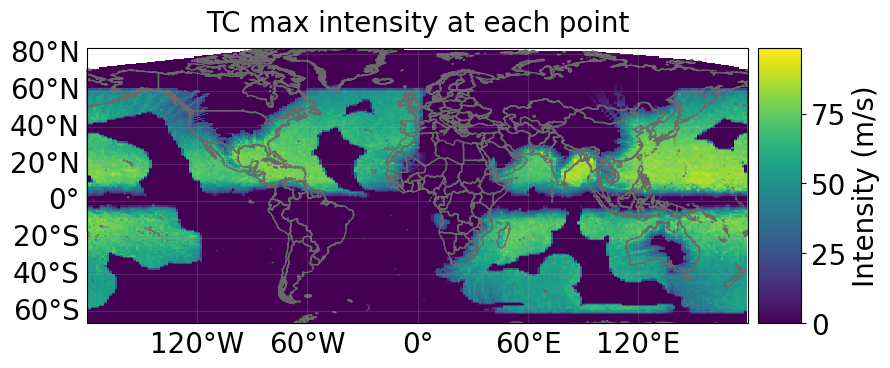

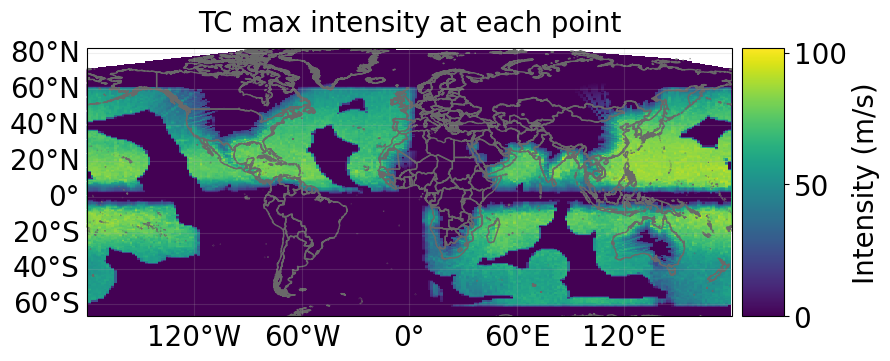

In [7]:
# Make a dictionary and store current and future hazard sets

# Initialise the client
client = Client()

# Get the hazard set info
hazard_type = 'tropical_cyclone'
info_tc = client.list_dataset_infos('tropical_cyclone')
print(client.get_property_values(info_tc))

# Store the currrent hazard sets in a dictionary
haz_dict = {}

# Get the current hazard set
properties_curr = {'model_name': 'STORM', 'spatial_coverage': 'global', 'name':'TC_global_0300as_STORM'}
haz_dict[time_periods[0]] = client.get_hazard(hazard_type, properties=properties_curr)

# Get the future hazard set
fut_haz_names = ['TC_global_0300as_STORM_CNRM-CM6-1-HR', 'TC_global_0300as_STORM_EC-Earth3P-HR'] # Possible future hazard sets from the API 
properties_fut = {'model_name': 'STORM', 'spatial_coverage': 'global', 'name': fut_haz_names[0]}
# properties_fut = properties_curr
haz_dict[time_periods[1]] = client.get_hazard(hazard_type, properties=properties_fut)

# Plot the hazard set
haz_dict[time_periods[0]].plot_intensity(0)
haz_dict[time_periods[1]].plot_intensity(0)



## Impact functions

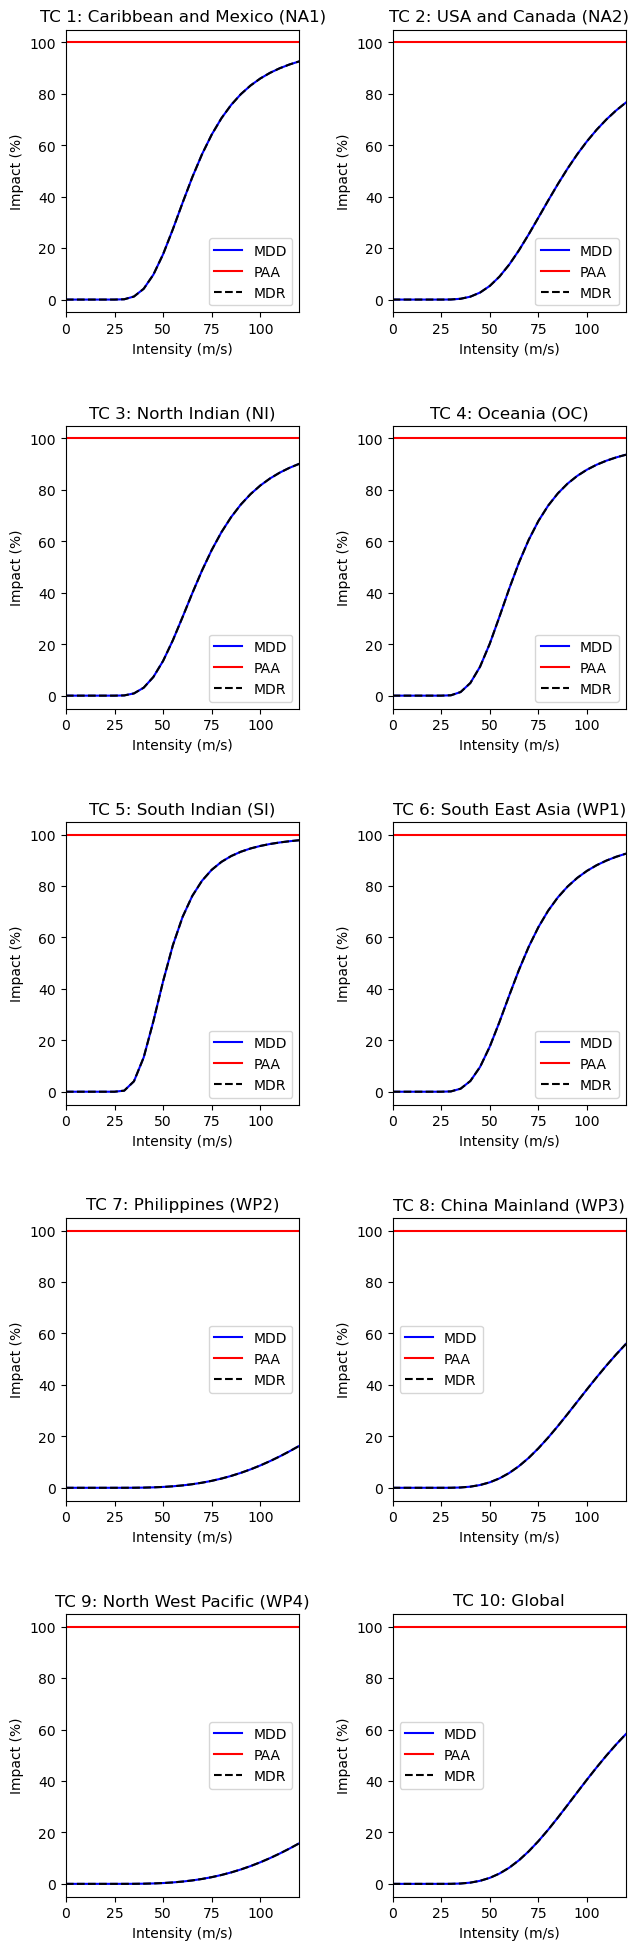

In [8]:
# generate the default calibrated TC impact functions for different regions
imp_fun_set_TC = ImpfSetTropCyclone.from_calibrated_regional_ImpfSet()

# plot all the impact functions
imp_fun_set_TC.plot()
# adjust the plots
plt.subplots_adjust(right=1., top=4., hspace=0.4, wspace=0.4)

## Impact objects

In [9]:
# Calculate the impact (brutto and netto) for the current and future hazard sets

# Store the impact in a dictionary
imp_dict = {}

# Compute impact on historical hazard set
imp_dict = {time_periods[0]: {'brutto': {}, 'netto': {}}, time_periods[1]: {'brutto': {}, 'netto': {}}}

for time, haz in haz_dict.items():
    for cpny, exp in exp_dict[time].items():
        imp_dict[time]['brutto'][cpny] = ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=True, ignore_cover=True, ignore_deductible=True)
        imp_dict[time]['netto'][cpny] = ImpactCalc(exp, imp_fun_set_TC, haz).impact(save_mat=True)


In [10]:
# Compute the total asset value for each company
asset_value_df = pd.DataFrame(index=exp_df[company_ref].unique(), columns=time_periods)
for time, exp_time_dict in exp_dict.items():
    for cpny, exp in exp_time_dict.items():
        asset_value_df.loc[cpny, time] = exp.gdf.value.sum()

# Calc the EAI for the current and future hazard sets and brutto and netto impact
EAI_df = pd.DataFrame(index=exp_df[company_ref].unique(), columns=[time_periods[0] + '_brutto', time_periods[0] + '_netto', time_periods[1] + '_brutto', time_periods[1] + '_netto'])
EAI_rel_df = EAI_df.copy() # relative EAI

# Python
# Compute the EAI for the current and future hazard sets and brutto and netto impact
for time, imp_type_dict in imp_dict.items():
    for imp_type, cpny_dict in imp_type_dict.items():
        for cpny, imp in cpny_dict.items():
            EAI_df.loc[cpny, time + '_' + imp_type] = imp.aai_agg
            EAI_rel_df.loc[cpny, time + '_' + imp_type] = imp.aai_agg / asset_value_df.loc[cpny, time]

# Add (%) to the column names of the realtive EAI df and multiply by 100
EAI_rel_df.columns = [col + ' (%)' for col in EAI_rel_df.columns]
EAI_rel_df = EAI_rel_df * 100

# Print the EAI 
print(EAI_df, 2*'\n')
print(EAI_rel_df)


    current_brutto current_netto future_brutto future_netto
1.0       0.025698      0.001928      0.044657     0.005957
2.0       0.010795      0.006441      0.016868     0.010708
3.0        0.00027      0.000205        0.0003     0.000231 


    current_brutto (%) current_netto (%) future_brutto (%) future_netto (%)
1.0           0.075472          0.005664           0.13115         0.017494
2.0           0.107952          0.064407          0.168683         0.107078
3.0           0.247736          0.187792          0.275488         0.211486


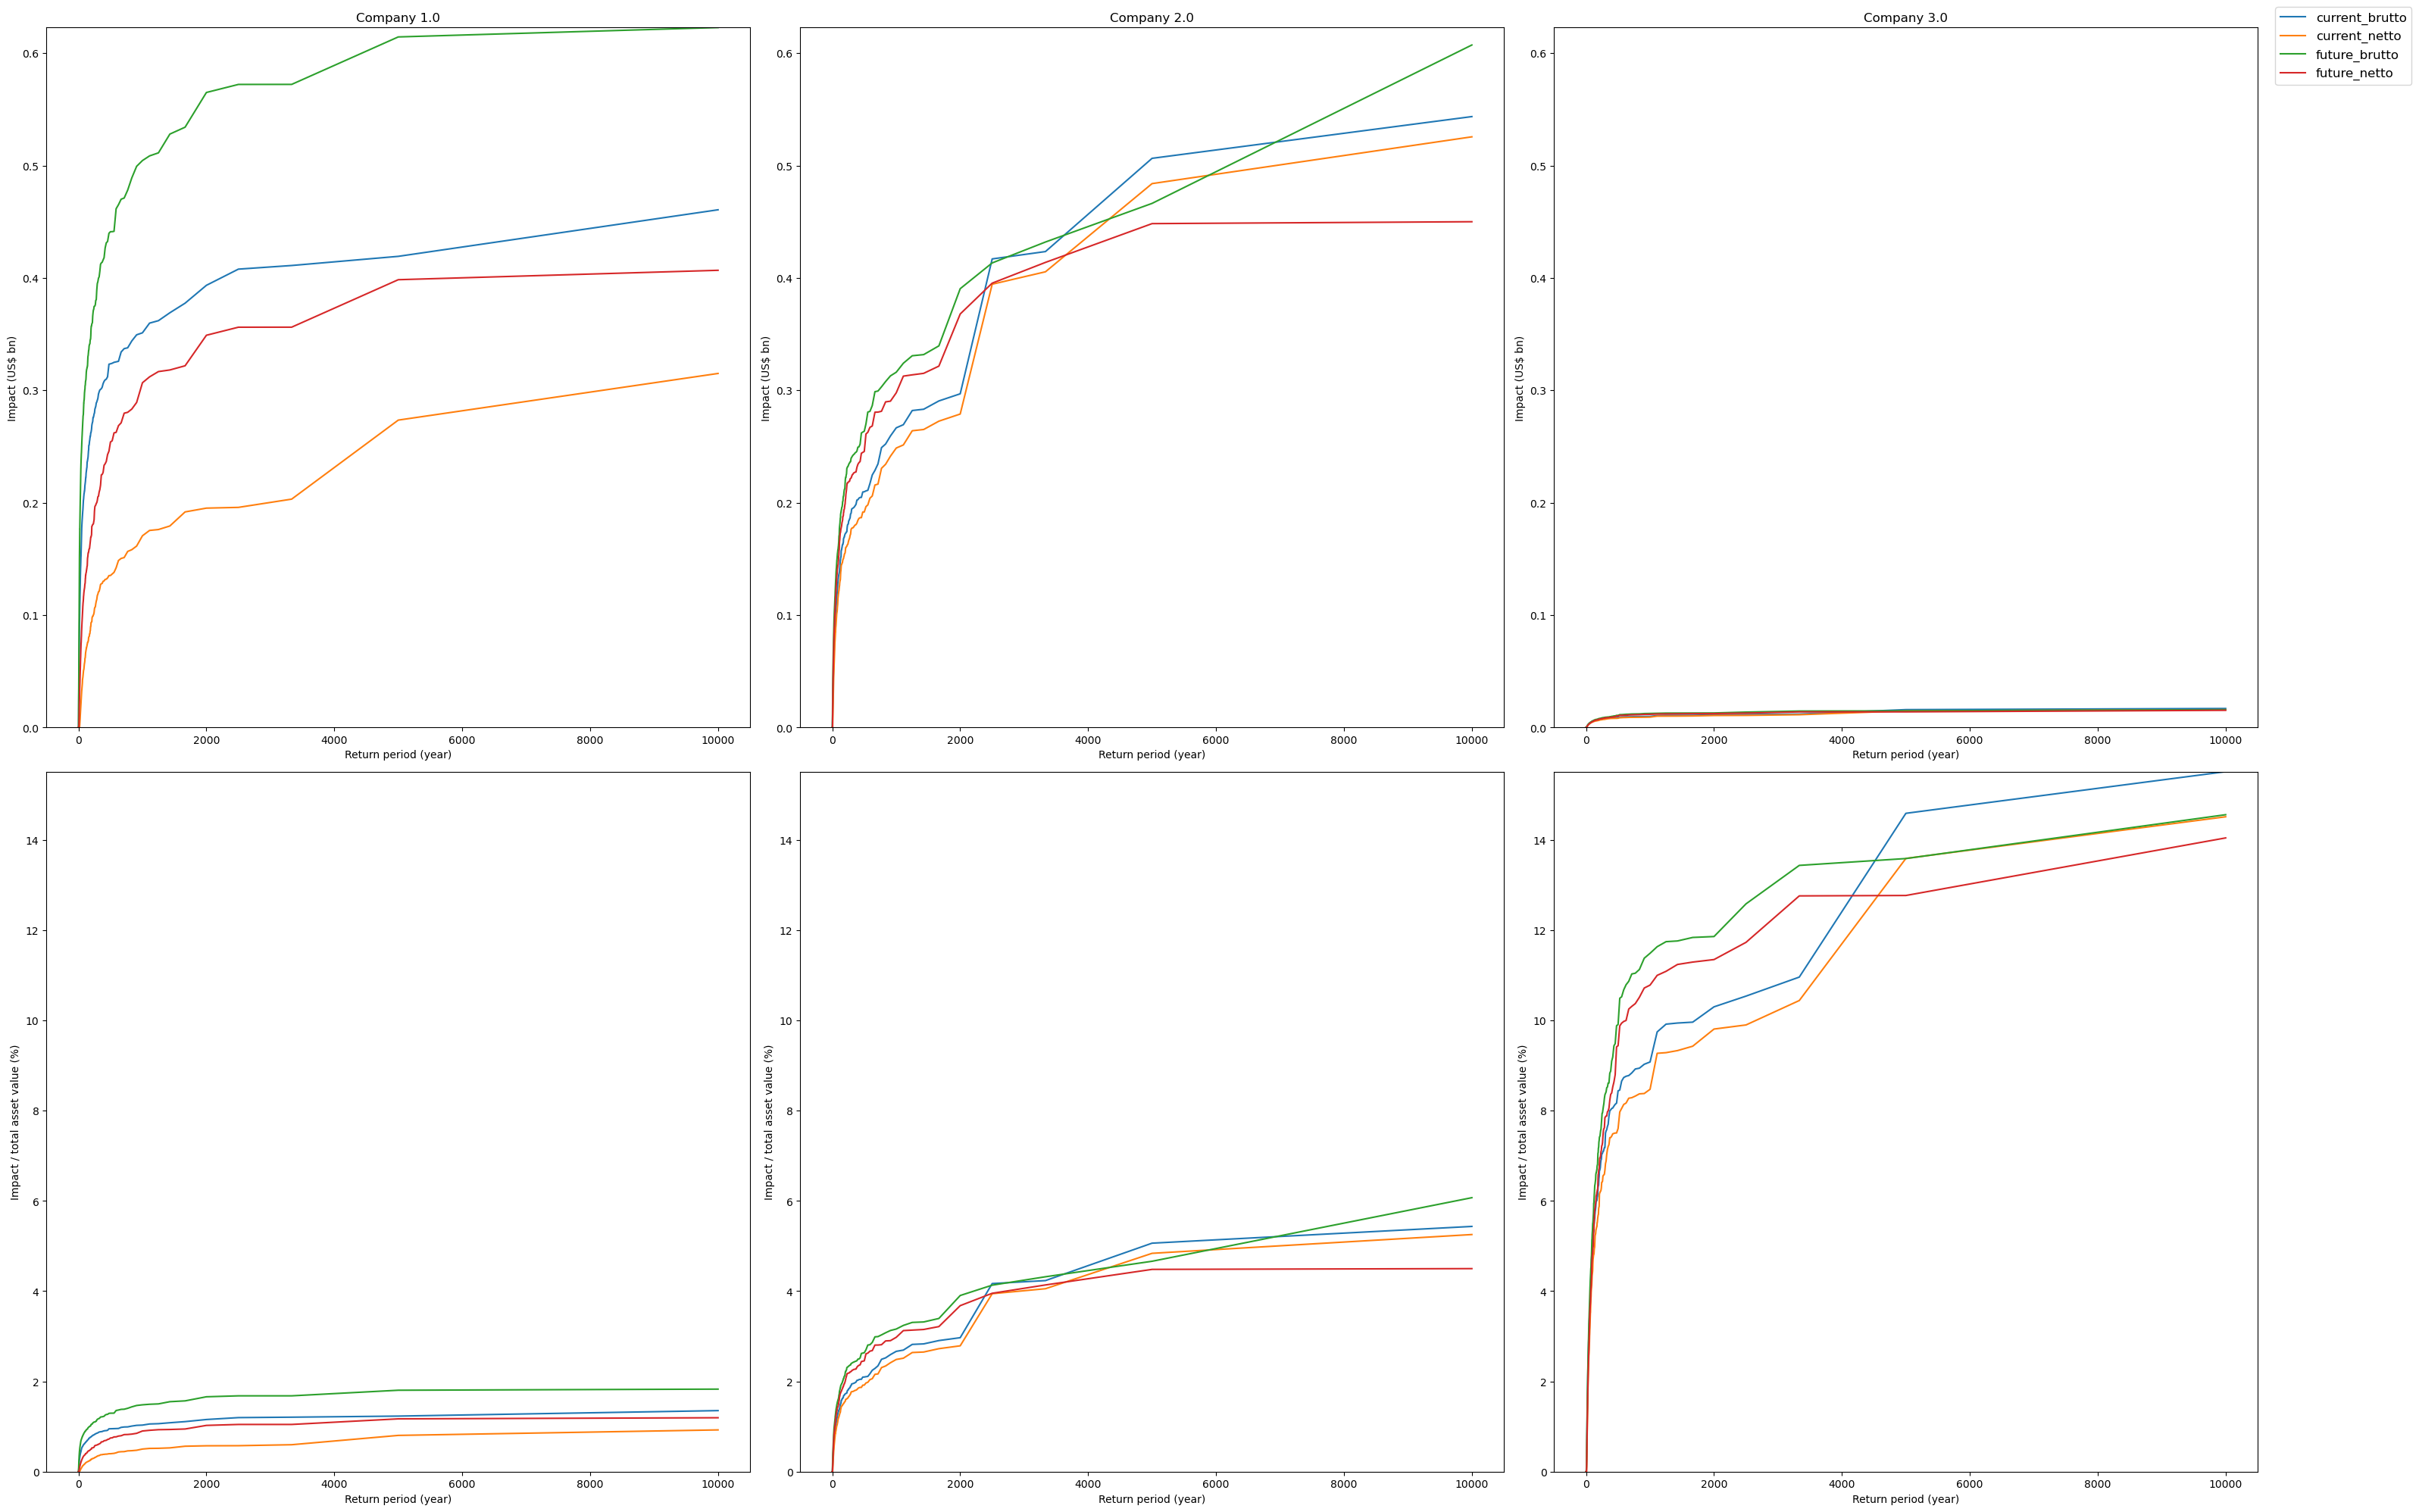

In [13]:
# Plot the retunr periods for each company

# Get the list of unique companies
companies = exp_df[company_ref].unique()

# Create a 2D grid of subplots
fig, axes = plt.subplots(2, len(companies), figsize=(10 * len(companies), 20))

# Set the y_max for absolute and relative EAI
y_max_abs = np.max([imp_dict[time][imp_type][cpny].calc_freq_curve().impact.max() for time in imp_dict for imp_type in imp_dict[time] for cpny in imp_dict[time][imp_type]])
y_max_rel = np.max([imp_dict[time][imp_type][cpny].calc_freq_curve().impact.max() / asset_value_df.loc[cpny, time]*100 for time in imp_dict for imp_type in imp_dict[time] for cpny in imp_dict[time][imp_type]])

# Loop over each company
for idx, cpny in enumerate(companies):
    # Set the company name as the column title
    axes[0, idx].set_title(f'Company {cpny}')
    axes[0, idx].set_ylim([0, y_max_abs])
    axes[1, idx].set_ylim([0, y_max_rel])

    axes[0, idx].set_ylabel('Impact (US$ bn)')
    axes[0, idx].set_xlabel('Return period (year)')

    axes[1, idx].set_ylabel('Impact / total asset value (%)')
    axes[1, idx].set_xlabel('Return period (year)')

    # Loop over the time periods and impact types from the imp_dict
    for time, imp_type_dict in imp_dict.items():
        for imp_type, cpny_dict in imp_type_dict.items():
            # Compute the frequency curve
            freq_curve = imp_dict[time][imp_type][cpny].calc_freq_curve()
            # Plot the frequency curve
            axes[0, idx].plot(freq_curve.return_per, freq_curve.impact, label=str(time + '_' + imp_type))
            # Plot the frequency curve relative to the asset value
            axes[1, idx].plot(freq_curve.return_per, freq_curve.impact / asset_value_df.loc[cpny, time]*100, label=str(time + '_' + imp_type))  # multiply by 100 to get in prct

# Add a title to the legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize='large')

plt.tight_layout()
plt.show()

## Risk dependency - Spatial correlation analysis

In [52]:
# Create a data frame containing the sampled impacts for each company per year and event

# The number of years to sample impacts for (length(yimp.at_event) = sampled_years)
sampled_years = 10000

# Create a data frame containing the sampled impacts for each company per year and event
imp_per_year_abs_dict = {time: {imp_type: pd.DataFrame() for imp_type in imp_type_dict.keys()} for time, imp_type_dict in imp_dict.items()}
imp_per_year_rel_dict = copy.deepcopy(imp_per_year_abs_dict)
imp_per_event_abs_dict = copy.deepcopy(imp_per_year_abs_dict)
imp_per_event_rel_dict = copy.deepcopy(imp_per_year_abs_dict)

sampling_vect_dict = {} # Store the sampling vector for time period
all_sampled_events_dict = {} # Store all the sampled events for time period

#all_sampled_events.astype(int).tolist()

for time, imp_type_dict in imp_dict.items():

    # Get any coapny impact object for the current time to sample the event ids
    imp_temp = imp_dict[time]['brutto'][cpny]

    # sample number of events per sample year
    lam = np.sum(imp.frequency)
    events_per_year = yearsets.sample_from_poisson(sampled_years, lam)

    # generate and store the sampling vector
    sampling_vect_dict[time] = yearsets.sample_events(events_per_year, imp_temp.frequency)

    # Store all smapled events in one array
    all_sampled_events_dict[time] = np.array([])
    for year_sample in sampling_vect_dict[time]:
        all_sampled_events_dict[time] = np.concatenate((all_sampled_events_dict[time], year_sample))
    # Make as integer and list
    all_sampled_events_dict[time] = all_sampled_events_dict[time].astype(int).tolist()

    
    # calculate the absolute and relative sampled impact per year and event for each company and store in a data frame
    for imp_type, cpny_dict in imp_type_dict.items():

        # Store the financial impact for each company per year and event in a data frame where each column is a company
        for cpny, imp in cpny_dict.items():
            # Store the impact per year for each company
            imp_per_year_abs_dict[time][imp_type][cpny] = yearsets.compute_imp_per_year(imp, sampling_vect_dict[time]) 
            imp_per_year_rel_dict[time][cpny] = imp_per_year_abs_dict[time][imp_type][cpny]/asset_value_df.loc[cpny, time]

            # Store the impact per event for each company
            imp_per_event_abs_dict[time][imp_type][cpny] = imp.at_event[all_sampled_events_dict[time]]
            imp_per_event_rel_dict[time][imp_type][cpny] = imp_per_event_abs_dict[time][imp_type][cpny]/asset_value_df.loc[cpny, time]


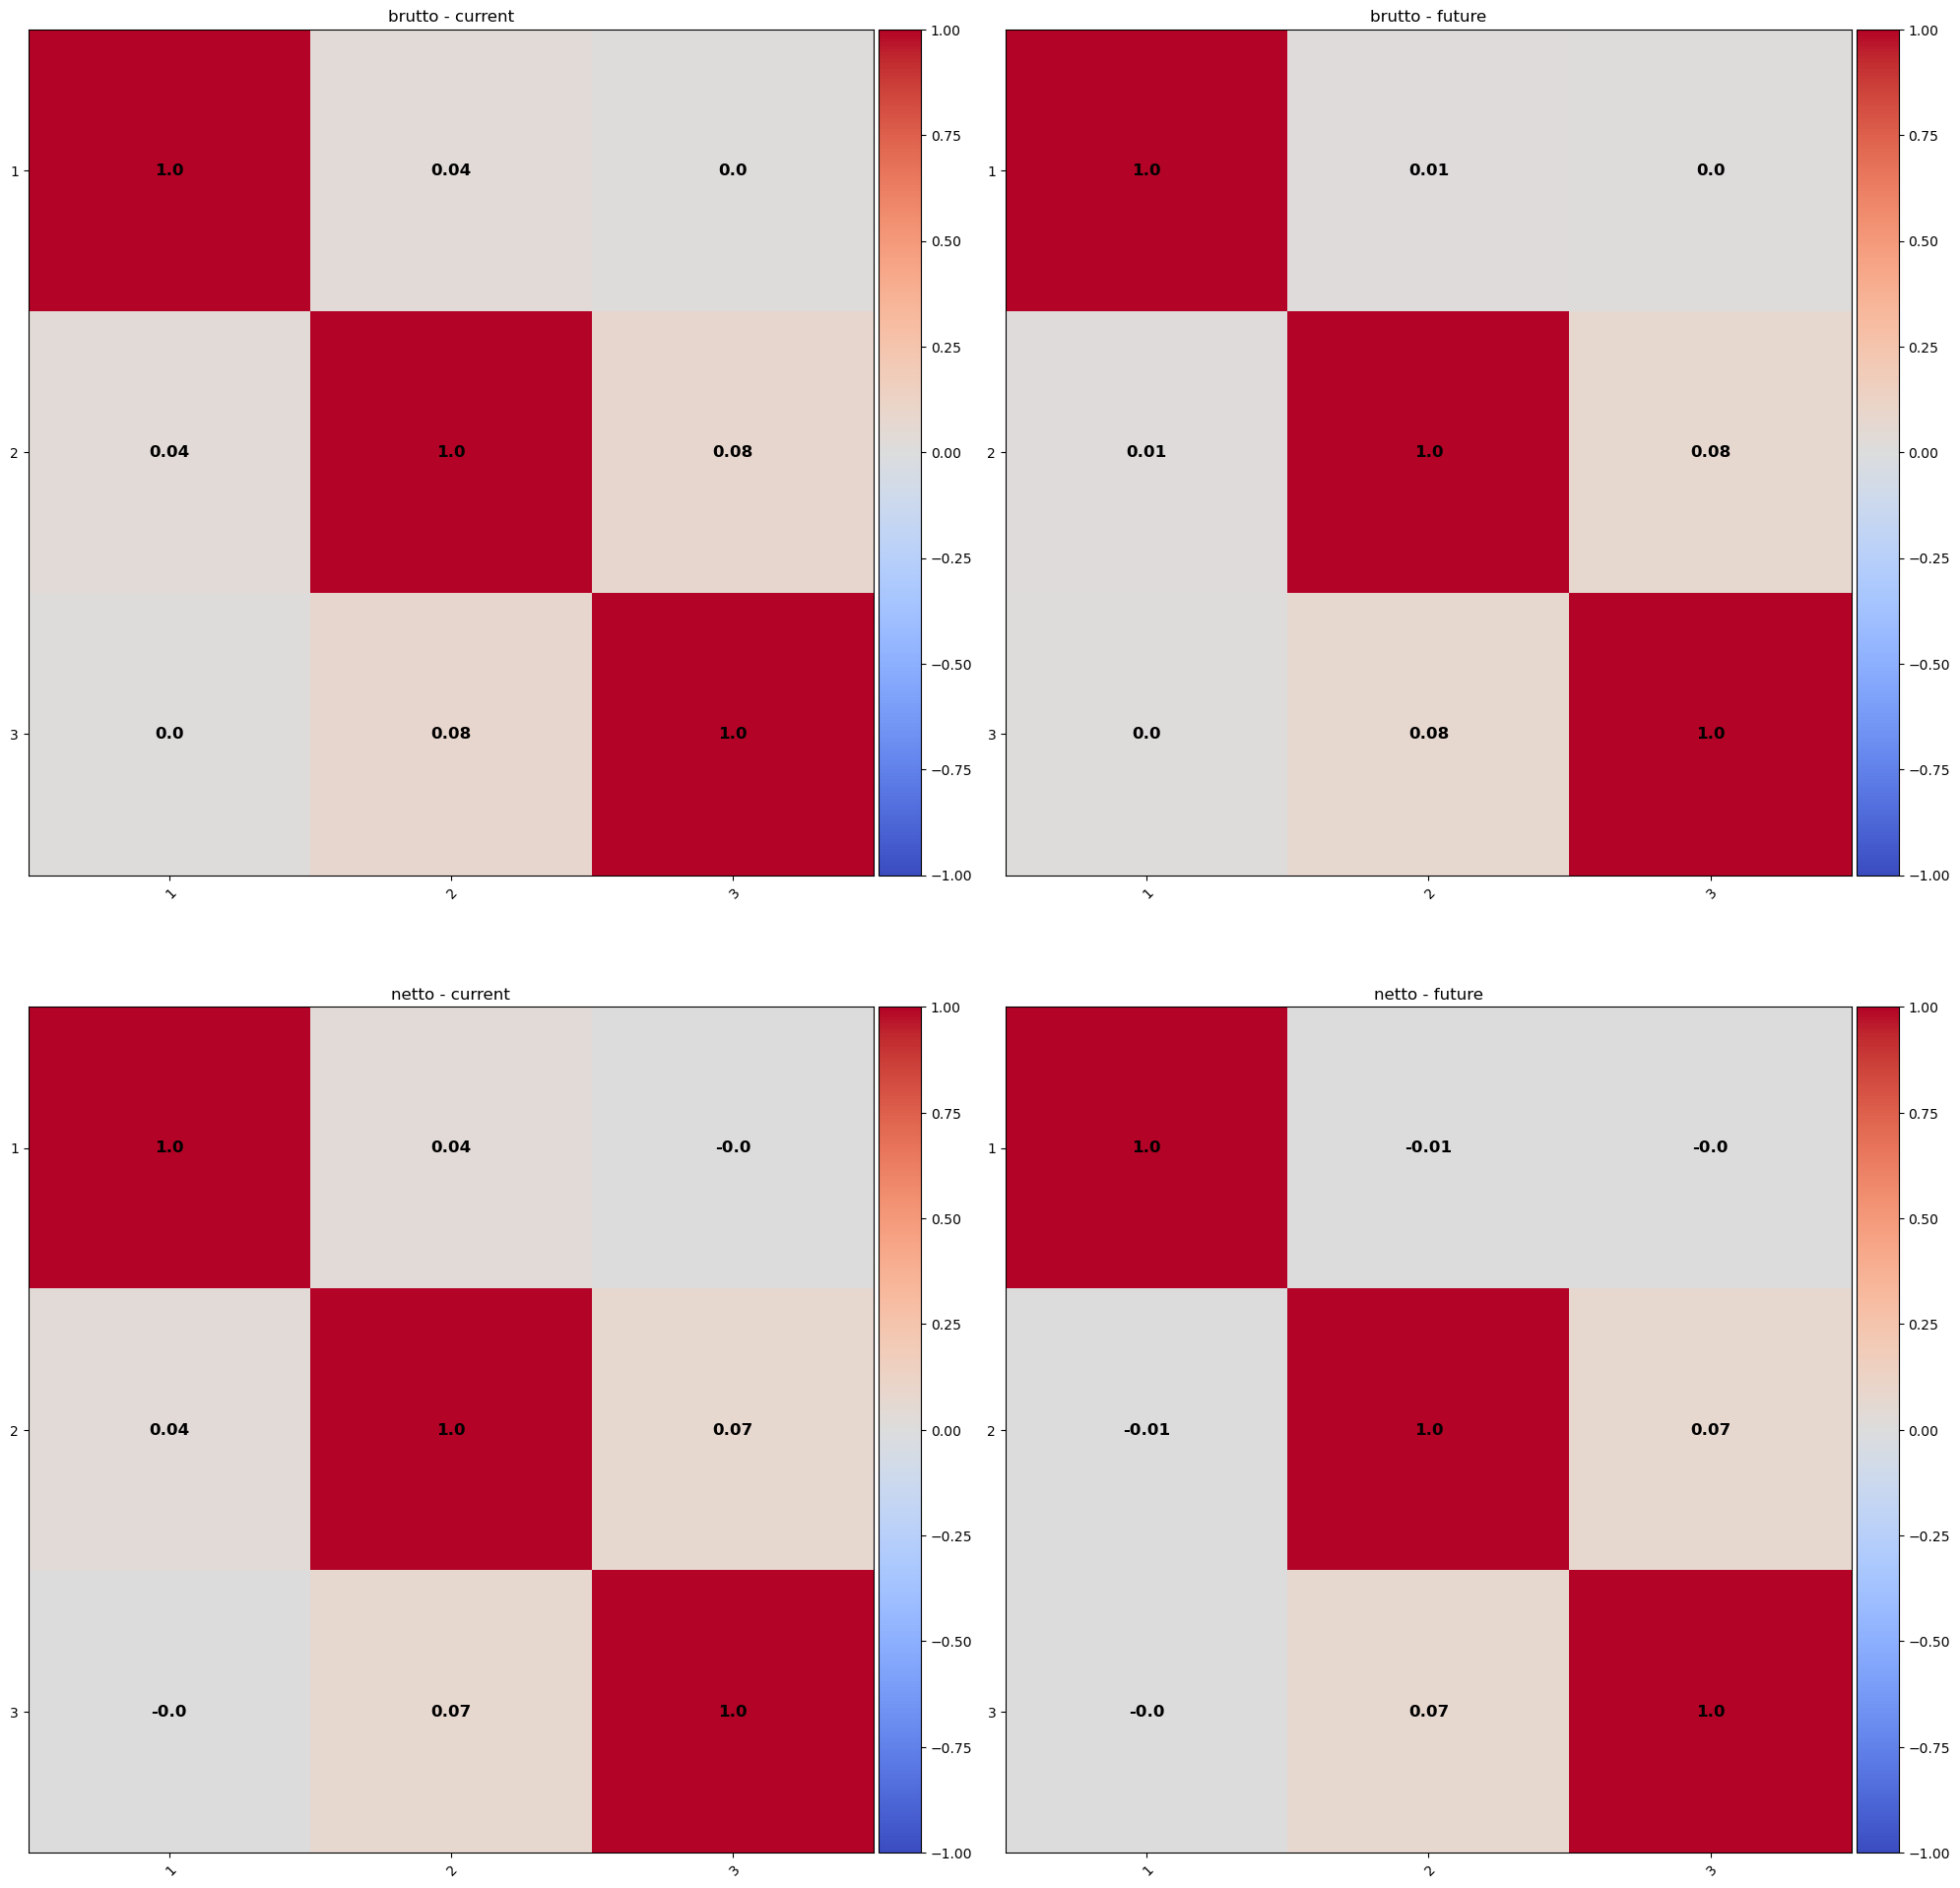

In [103]:
# Calculate the yearly correlation matrix

# Create the correlation matrix containers
corr_per_year_abs_dict = {time: {imp_type: pd.DataFrame() for imp_type in imp_type_dict.keys()} for time, imp_type_dict in imp_dict.items()}
corr_per_year_rel_dict = copy.deepcopy(corr_per_year_abs_dict)

# Calculate the correlation matrix for each company and store in a data frame
for time, imp_type_dict in imp_dict.items():
    for imp_type, cpny_dict in imp_type_dict.items():
        corr_per_year_abs_dict[time][imp_type] = imp_per_year_abs_dict[time][imp_type].corr()
        corr_per_year_rel_dict[time][imp_type] = imp_per_year_rel_dict[time][imp_type].corr()


from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot the correlation matrix for each company
fig, axes = plt.subplots(len(imp_dict[time_periods[0]]), len(time_periods), figsize=(10 * len(time_periods), 10 * len(imp_dict[time_periods[0]])))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Loop over the time periods and impact types from the imp_dict
for time, imp_type_dict in imp_dict.items():
    for imp_type, cpny_dict in imp_type_dict.items():
        # Get the correlation matrix
        corr_matrix = corr_per_year_abs_dict[time][imp_type]

        # Plot the correlation matrix
        im = axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

        # Create a new axes on the right side of the current axes
        divider = make_axes_locatable(axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)])
        cax = divider.append_axes("right", size="5%", pad=0.05)

        # Add the colorbar to the new axes
        fig.colorbar(im, cax=cax, orientation='vertical')

        # Set the x and y ticks
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_xticks(np.arange(len(corr_matrix.columns)))
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_yticks(np.arange(len(corr_matrix.columns)))

        # Set the x and y tick labels
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_xticklabels(corr_matrix.columns)
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_yticklabels(corr_matrix.columns)

        # Rotate the tick labels and set their alignment
        plt.setp(axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")
        
        # Loop over the rows and columns of the correlation matrix and add the value to the plot
        for i in range(len(corr_matrix.columns)):
            for j in range(len(corr_matrix.columns)):
                axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].text(j, i, round(corr_matrix.iloc[i, j], 2), ha="center", va="center",  fontsize=12, weight='bold')

        # Add a title to the plot
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_title(f'{imp_type} - {time}')


plt.tight_layout()
plt.show()



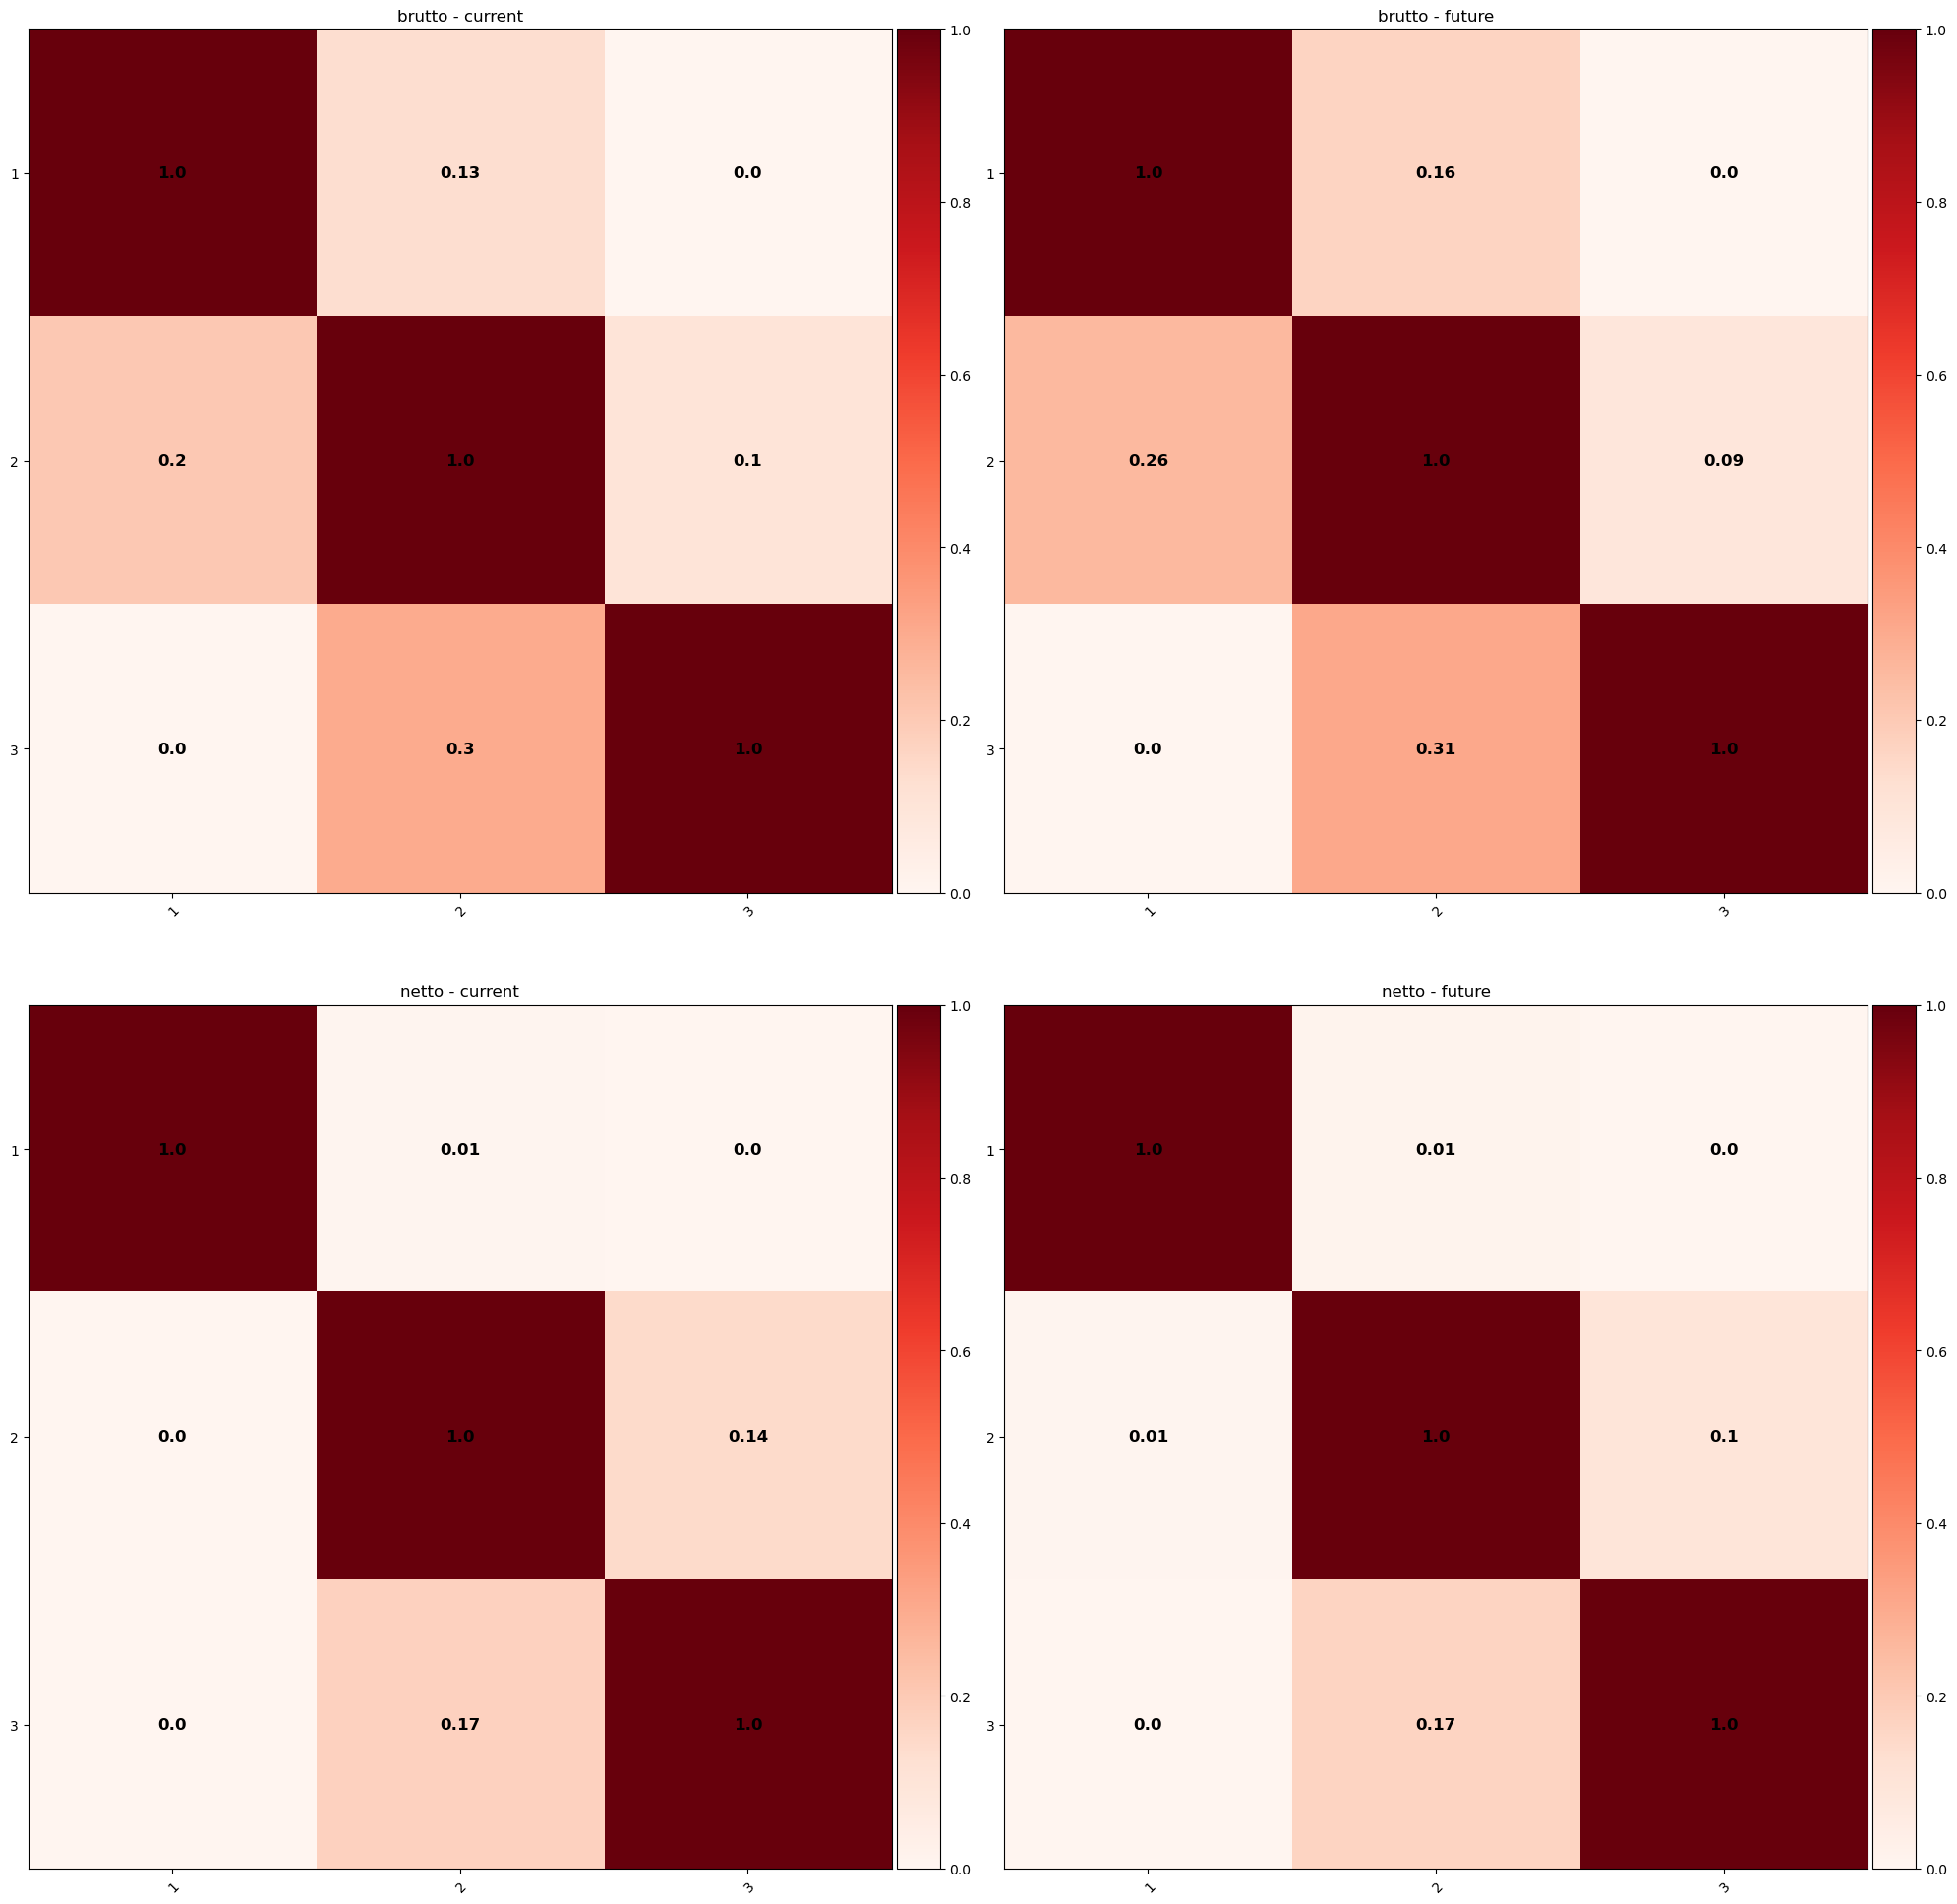

In [124]:
# Calculate the conditional probability of a company being impacted given that another company is impacted

# Create a data frame with company names as indeax and columns
base_df = pd.DataFrame(index=imp_per_event_abs_dict[time_periods[0]]['brutto'].columns, columns=imp_per_event_abs_dict[time_periods[0]]['brutto'].columns)

# Create the conditional probability containers
cond_prob_dict = {time: {imp_type: base_df.copy() for imp_type in imp_type_dict.keys()} for time, imp_type_dict in imp_dict.items()}

for time, imp_type_dict in imp_dict.items():
    for imp_type, cpny_dict in imp_type_dict.items():
        # Calculate the conditional probability for each company
        for cpny1 in base_df.columns:
            # Get the events where the company 1 is impacted
            temp_1 = imp_per_event_abs_dict[time][imp_type][cpny1] > 0
            for cpny2 in base_df.columns:
                # Get the events where the company 2 is impacted
                temp_2 = imp_per_event_abs_dict[time][imp_type][cpny2] > 0
                # Calculate the conditional probability
                # the index postion should be cpny2 which can be a string also and the columns should be cpny1 whcih can be a string
                cond_prob_dict[time][imp_type].loc[cpny1, cpny2] = np.sum(temp_1 & temp_2)/np.sum(temp_1)
        
        # Convert the DataFrame to float
        cond_prob_dict[time][imp_type] = cond_prob_dict[time][imp_type].astype(float)


# Plot the conditional probability
                
# Plot the correlation matrix for each company
fig, axes = plt.subplots(len(imp_dict[time_periods[0]]), len(time_periods), figsize=(10 * len(time_periods), 10 * len(imp_dict[time_periods[0]])))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for time, imp_type_dict in imp_dict.items():
    for imp_type, cpny_dict in imp_type_dict.items():
        # Get the conditional probability matrix
        cond_prob_matrix = cond_prob_dict[time][imp_type]

        # Plot the conditional probability matrix
        im = axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].imshow(cond_prob_matrix, cmap='Reds', vmin=0, vmax=1)

        # Create a new axes on the right side of the current axes
        divider = make_axes_locatable(axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)])
        cax = divider.append_axes("right", size="5%", pad=0.05)

        # Add the colorbar to the new axes
        fig.colorbar(im, cax=cax, orientation='vertical')

        # Set the x and y ticks
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_xticks(np.arange(len(cond_prob_matrix.columns)))
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_yticks(np.arange(len(cond_prob_matrix.columns)))

        # Set the x and y tick labels
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_xticklabels(cond_prob_matrix.columns)
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_yticklabels(cond_prob_matrix.columns)

        # Rotate the tick labels and set their alignment
        plt.setp(axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].get_xticklabels(), rotation=45, ha="right",
                rotation_mode="anchor")
        
        # Loop over the rows and columns of the conditional probability matrix and add the value to the plot
        for i in range(len(cond_prob_matrix.columns)):
            for j in range(len(cond_prob_matrix.columns)):
                axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].text(j, i, round(cond_prob_matrix.iloc[i, j], 2), ha="center", va="center", fontsize=12, weight='bold')

        # Add a title to the plot
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_title(f'{imp_type} - {time}')

plt.tight_layout()
plt.show()

## Portfolio analysis

### Minimizing the return period

In [139]:
# Make a function that calculates the return period for a portfolio of companies
def calc_imp_metric(cpny_weights, imp_list, market_cap, return_period = 100):
    imp_rel_chg_port = copy.deepcopy(imp_list[0]) # gives the relative change in impact
    imp_rel_chg_port.at_event = np.zeros(len(imp_rel_chg_port.at_event))
    for idx, imp in enumerate(imp_list):
        imp_rel_chg_port.at_event += imp.at_event*cpny_weights[idx]/market_cap[idx]

    freq_curve = imp_rel_chg_port.calc_freq_curve(return_per=np.array([return_period]))
    
    return freq_curve.impact[0]

# Store the market caps
market_cap = []
for cpny in cpny_dict.keys():
    market_cap += [fin_data_df.loc[fin_data_df[company_ref] == cpny, 'Market cap'].values[0]]
            

In [158]:
# Prepare the portfolio optimization problem 
from scipy.optimize import minimize

# Define the objective function for minimization
def obj_fun_min(cpny_weights, imp_list, market_cap, return_period):
    return calc_imp_metric(cpny_weights, imp_list, market_cap, return_period)

# Define the objective function for maximization
def obj_fun_max(cpny_weights, imp_list, market_cap, return_period):
    return -calc_imp_metric(cpny_weights, imp_list, market_cap, return_period)

# Define the constraints
def constraint1(cpny_weights):
    return np.sum(cpny_weights) - 1

# Define the bounds
bounds = [(0,1)]*len(market_cap)

# Define the initial guess
x0 = np.ones(len(market_cap))/len(market_cap)

# Define the return period
# return_period = 100

# Define the constraints
con1 = {'type': 'eq', 'fun': constraint1}

In [186]:
# Define the return periods
return_periods = np.array([100, 250, 500, 1000, 2000, 5000, 10000])

# Define a base data frame to store the results
base_results_df = pd.DataFrame(index=return_periods, columns=['optimal', 'equal', 'worst'])

# Define a base data frame to store the weights where the columns are the companies
base_weights_df = pd.DataFrame(index=return_periods, columns = imp_dict[time_periods[0]]['brutto'].keys())

# Define a dictionary to store the results
results_rp_dict = {time: {imp_type: base_results_df.copy() for imp_type in imp_type_dict.keys()} for time, imp_type_dict in imp_dict.items()}

# Define a dictionary to store the weights add another key that is ['optimal', 'equal', 'worst']
weights_rp_dict = {time: {imp_type: {strategy: base_weights_df.copy() for strategy in base_results_df.columns}  for imp_type in imp_type_dict.keys()} for time, imp_type_dict in imp_dict.items()}


In [197]:
# Loop over the time periods and impact types from the imp_dict

for time, imp_type_dict in imp_dict.items():
    for imp_type, cpny_dict in imp_type_dict.items():
        # Loop over the return periods
        for return_period in return_periods:
            # Define the constraints
            
            # Optimize the portfolio
            res_min = minimize(obj_fun_min, x0, args=(list(imp_dict[time][imp_type].values()), market_cap, return_period), method='SLSQP', bounds=bounds, constraints=con1)
            res_max = minimize(obj_fun_max, np.ones(len(market_cap))/len(market_cap), args=(list(imp_dict[time][imp_type].values()), market_cap, return_period), method='SLSQP', bounds=bounds, constraints=con1)

            # Store the results
            results_rp_dict[time][imp_type].loc[return_period, 'optimal'] = res_min.fun
            results_rp_dict[time][imp_type].loc[return_period, 'equal'] = calc_imp_metric(np.ones(len(market_cap))/len(market_cap), list(imp_dict[time][imp_type].values()), market_cap, return_period)
            results_rp_dict[time][imp_type].loc[return_period, 'worst'] = calc_imp_metric(res_max.x, list(imp_dict[time][imp_type].values()), market_cap, return_period)

            # Store the weights
            weights_rp_dict[time][imp_type]['optimal'].loc[return_period] = res_min.x
            weights_rp_dict[time][imp_type]['equal'].loc[return_period] = np.ones(len(market_cap))/len(market_cap)
            weights_rp_dict[time][imp_type]['worst'].loc[return_period] = res_max.x

            # update the initial guess
            x0 = res_min.x
            

            


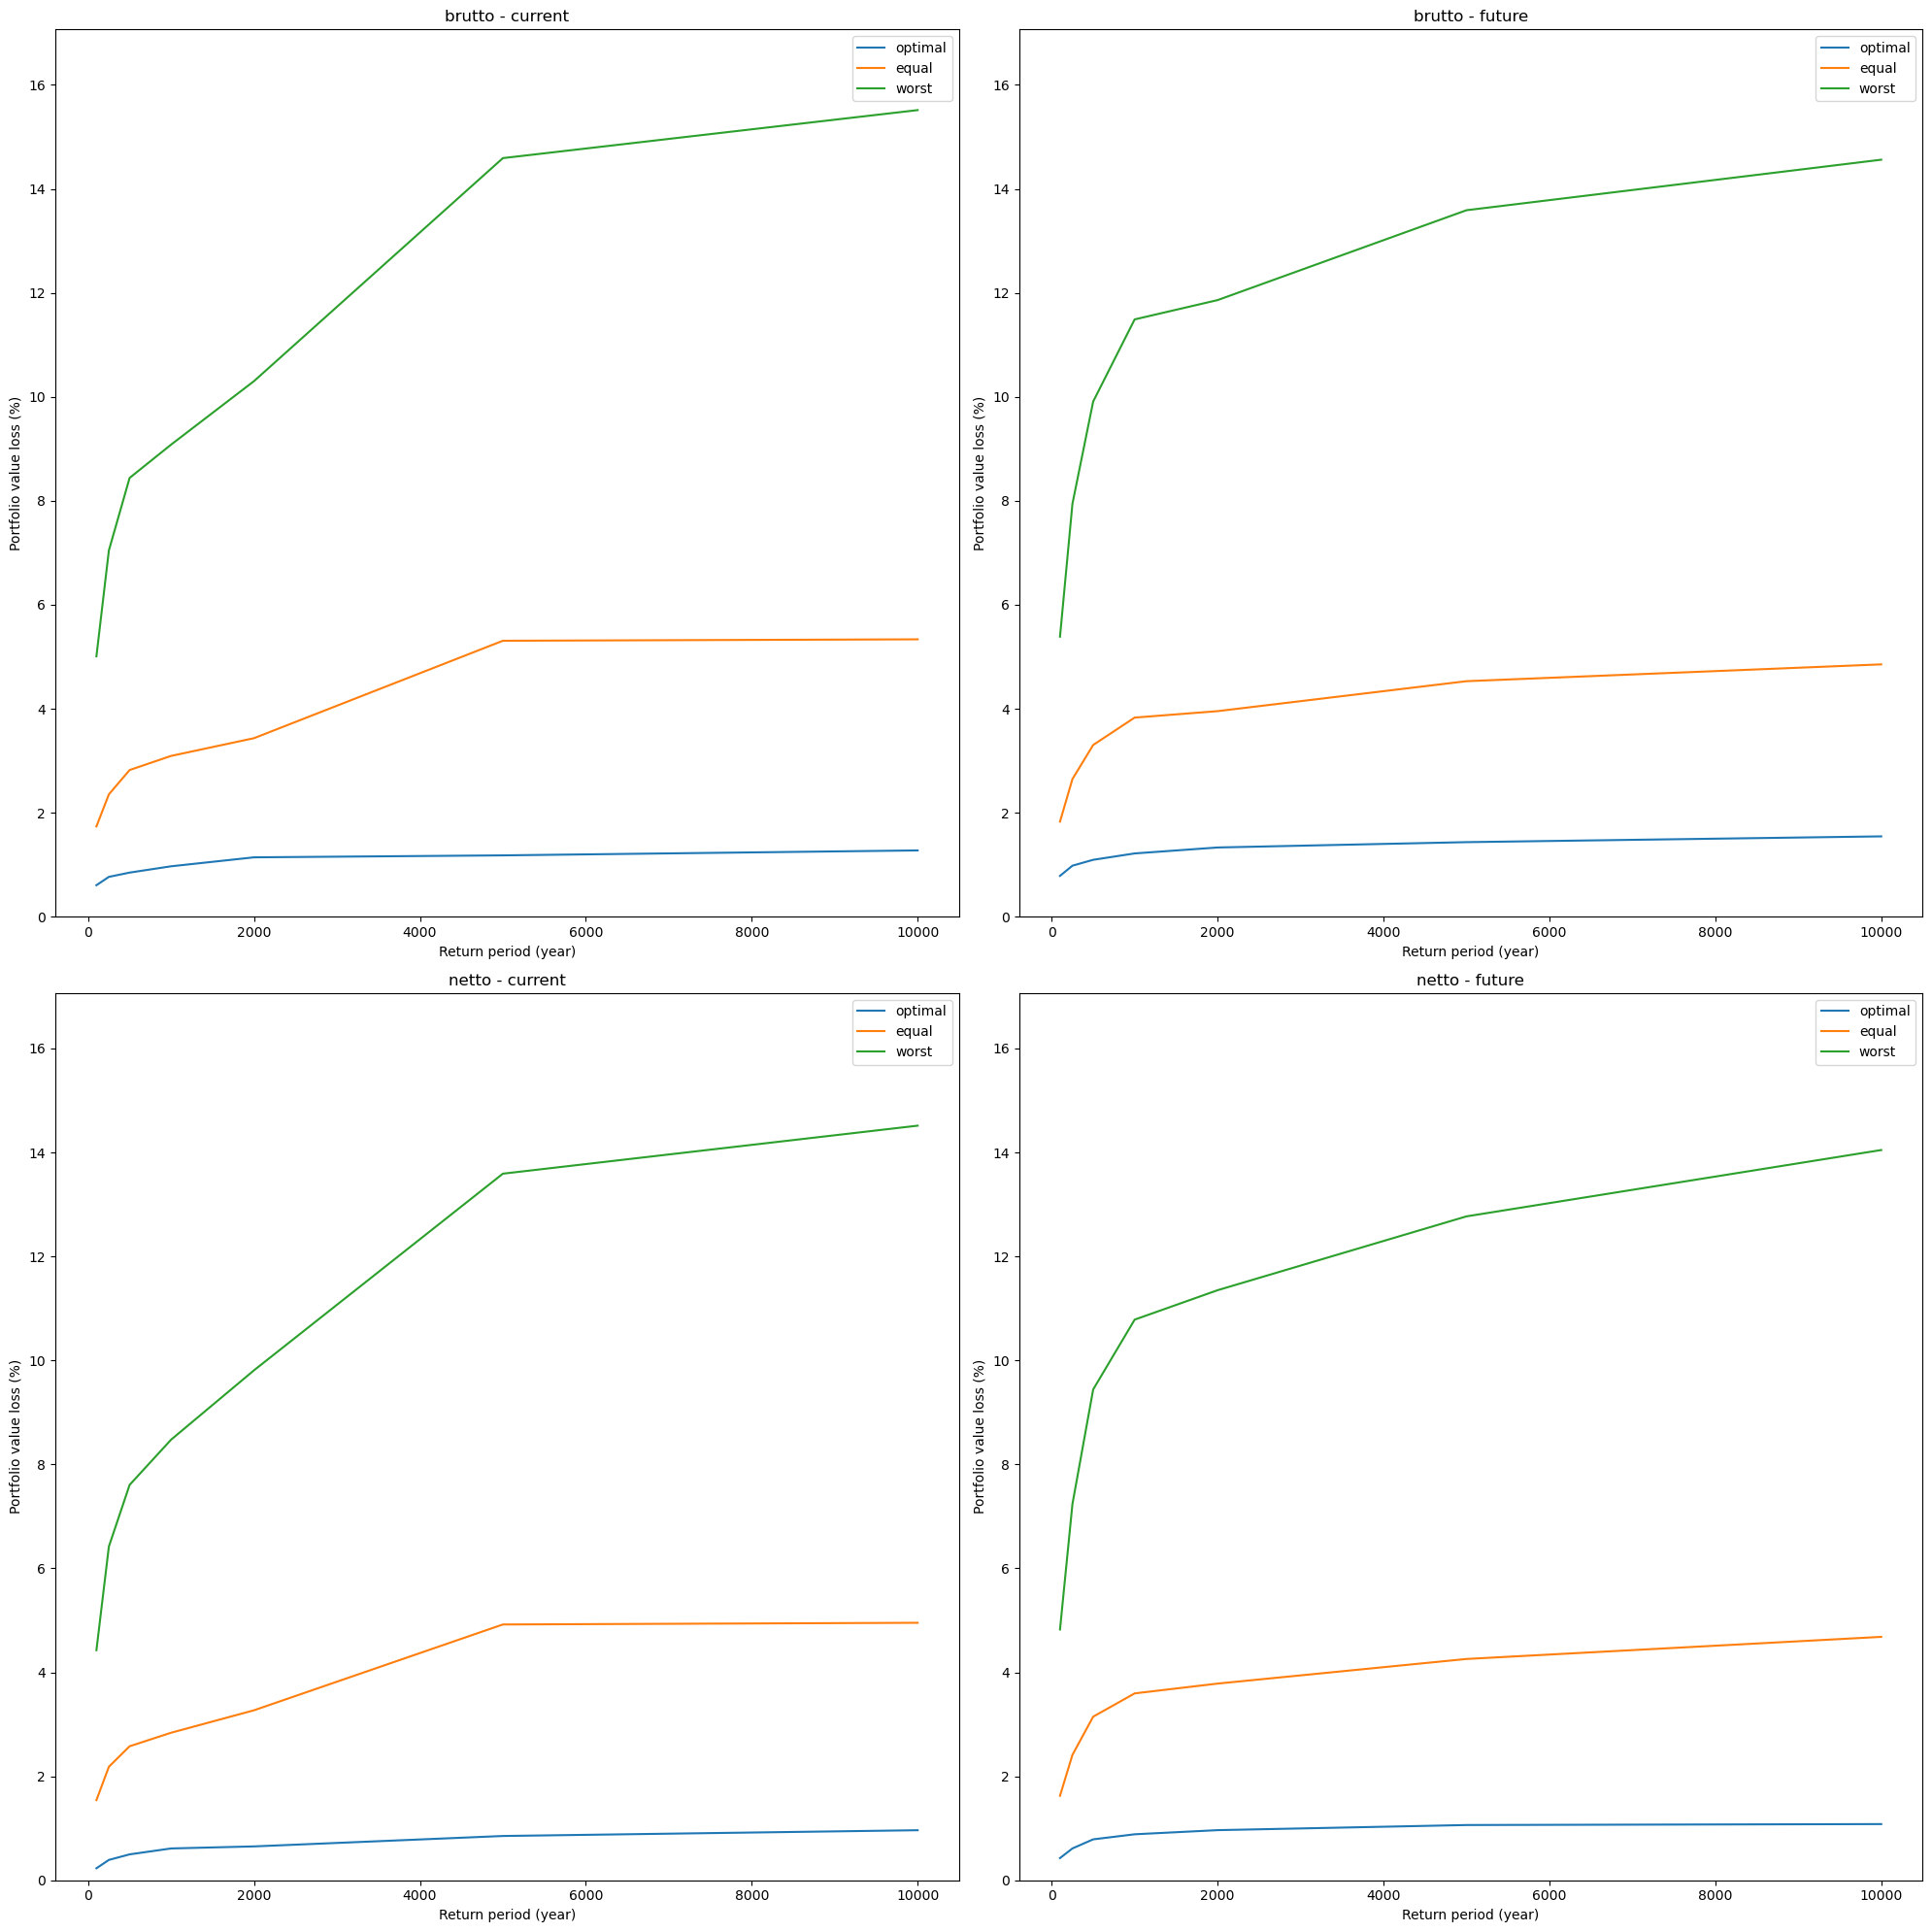

In [198]:
# Plot the results
# set the same y_max for all plots
y_max = np.max([results_rp_dict[time][imp_type].max().max() for time in results_rp_dict for imp_type in results_rp_dict[time]])*1.1

# Plot the correlation matrix for each company
fig, axes = plt.subplots(len(imp_dict[time_periods[0]]), len(time_periods), figsize=(10 * len(time_periods), 10 * len(imp_dict[time_periods[0]])))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for time, imp_type_dict in imp_dict.items():
    for imp_type, cpny_dict in imp_type_dict.items():
        # Plot the results
        lines = axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].plot(results_rp_dict[time][imp_type]*100) # multiply by 100 to get in prct
        # Add a legend to each subplot
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].legend(lines, results_rp_dict[time][imp_type].columns)
        # Add a title to the plot
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_title(f'{imp_type} - {time}')
        # Add x-axis label
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_xlabel('Return period (year)')
        # Add y-axis label
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_ylabel('Portfolio value loss (%)')
        # Set the y-axis limits
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_ylim([0, y_max*100])

plt.tight_layout()
plt.show()

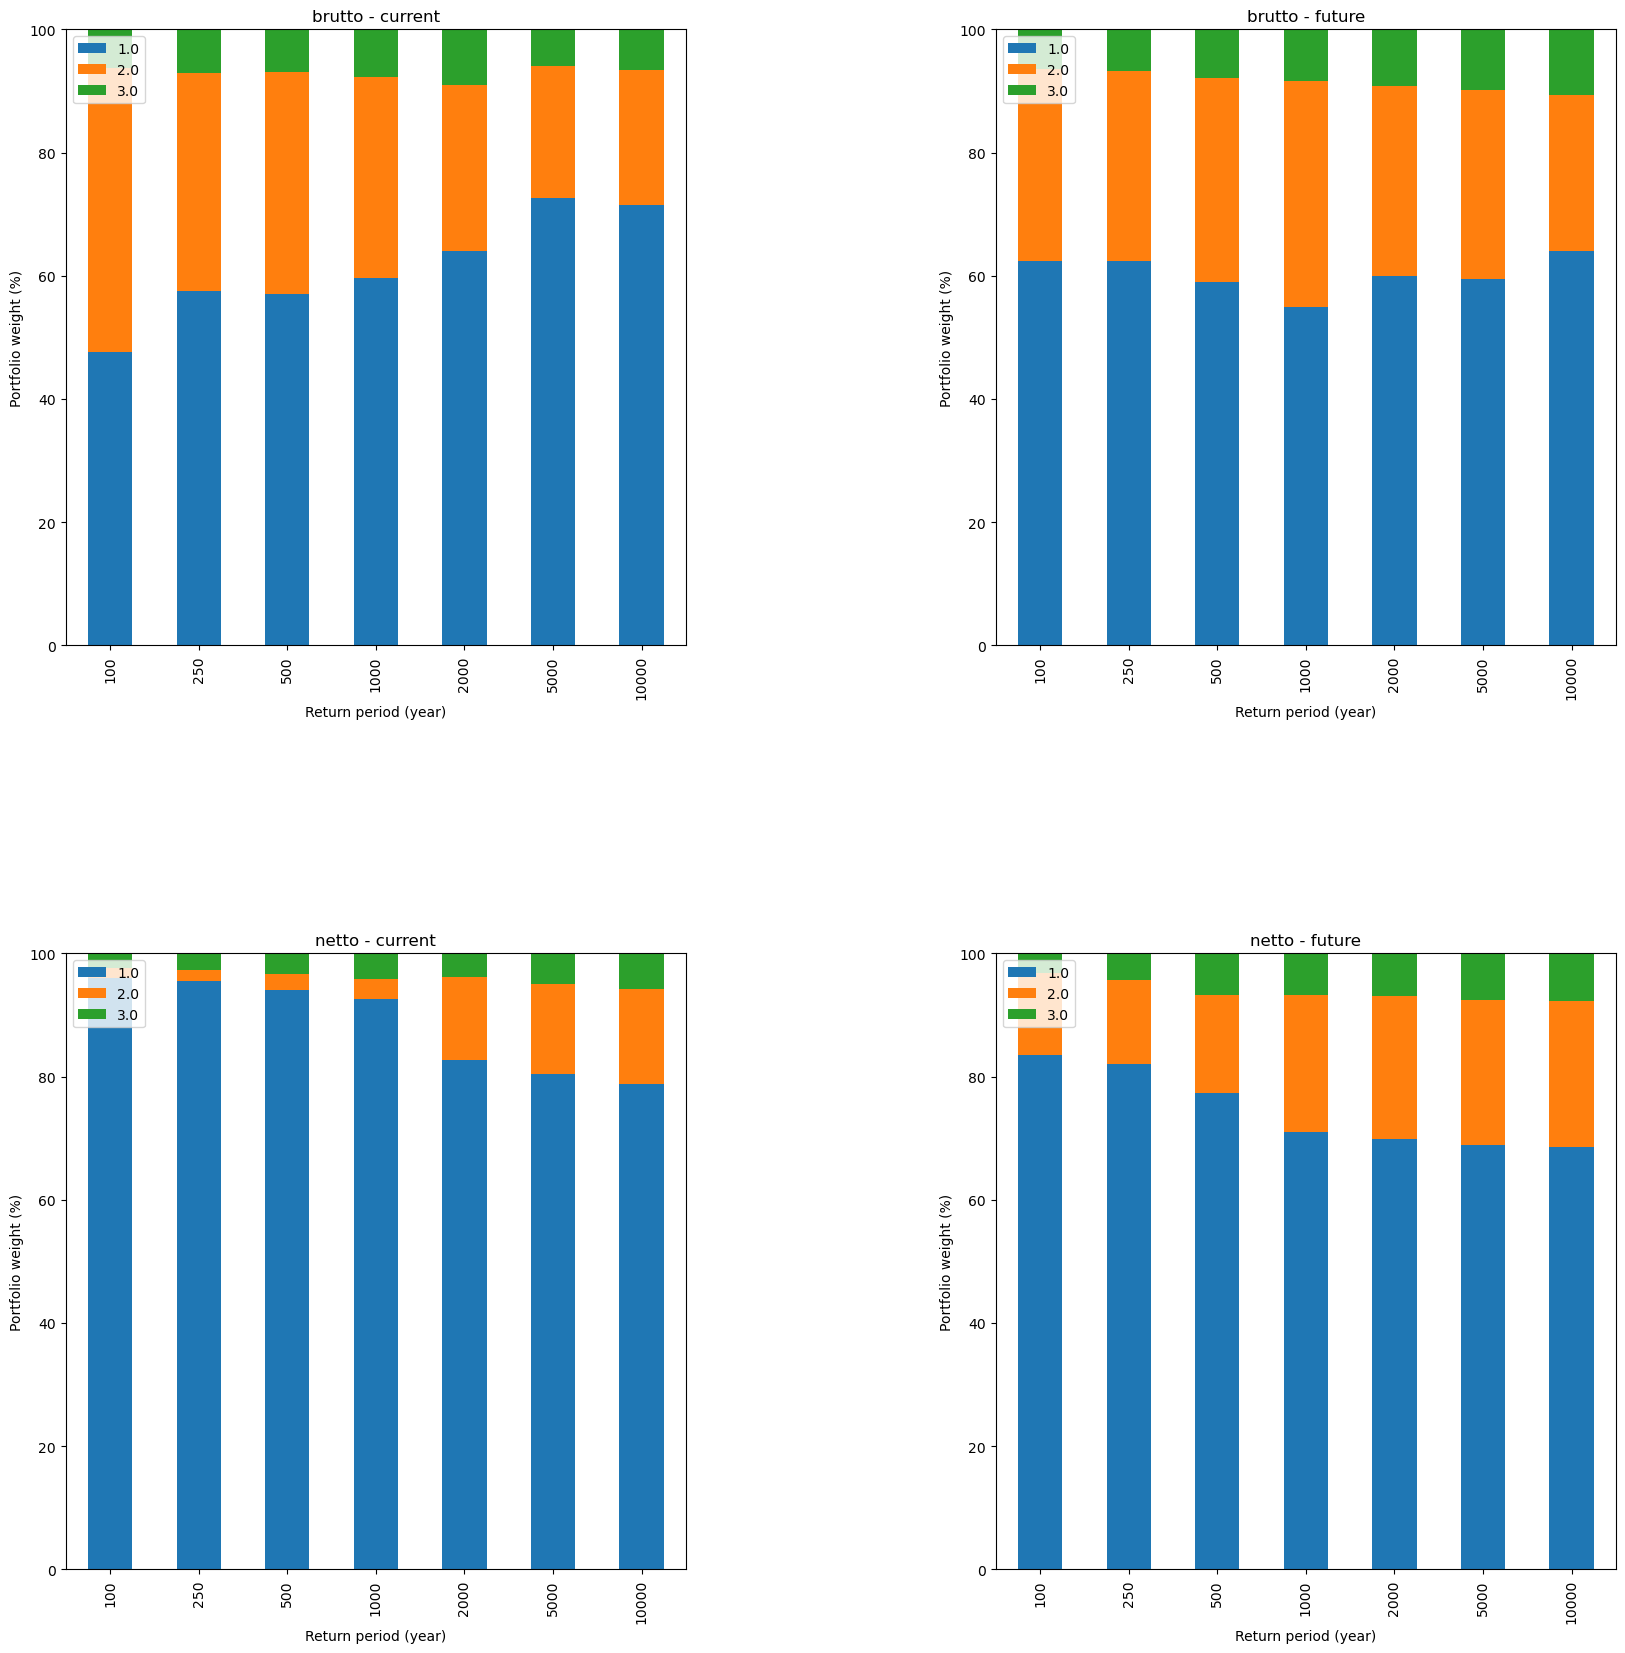

In [194]:
# Make subplot for each time period and impact type. Plot the weights for each company for each strategy stacked on top of each other. The x-axis is the return period and the y-axis is the weight of the company in the portfolio

# Plot the correlation matrix for each company
fig, axes = plt.subplots(len(imp_dict[time_periods[0]]), len(time_periods), figsize=(10 * len(time_periods), 10 * len(imp_dict[time_periods[0]])))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for time, imp_type_dict in imp_dict.items():
    for imp_type, cpny_dict in imp_type_dict.items():
        # Plot the results
        (weights_rp_dict[time][imp_type]['optimal']*100).plot.bar(stacked=True, ax=axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)])
        # Add a legend to each subplot
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].legend(loc='upper left')
        # Add a title to the plot
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_title(f'{imp_type} - {time}')
        # Add x-axis label
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_xlabel('Return period (year)')
        # Add y-axis label
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_ylabel('Portfolio weight (%)')
        # Set the y-axis limits
        axes[list(imp_type_dict.keys()).index(imp_type), list(imp_dict.keys()).index(time)].set_ylim([0, 100])


### Minimizing the Expected Shortfall

In [199]:
imp_per_event_abs_dict

{'current': {'brutto':           1    2    3
  0       0.0  0.0  0.0
  1       0.0  0.0  0.0
  2       0.0  0.0  0.0
  3       0.0  0.0  0.0
  4       0.0  0.0  0.0
  ...     ...  ...  ...
  712318  0.0  0.0  0.0
  712319  0.0  0.0  0.0
  712320  0.0  0.0  0.0
  712321  0.0  0.0  0.0
  712322  0.0  0.0  0.0
  
  [712323 rows x 3 columns],
  'netto':           1    2    3
  0       0.0  0.0  0.0
  1       0.0  0.0  0.0
  2       0.0  0.0  0.0
  3       0.0  0.0  0.0
  4       0.0  0.0  0.0
  ...     ...  ...  ...
  712318  0.0  0.0  0.0
  712319  0.0  0.0  0.0
  712320  0.0  0.0  0.0
  712321  0.0  0.0  0.0
  712322  0.0  0.0  0.0
  
  [712323 rows x 3 columns]},
 'future': {'brutto':           1    2    3
  0       0.0  0.0  0.0
  1       0.0  0.0  0.0
  2       0.0  0.0  0.0
  3       0.0  0.0  0.0
  4       0.0  0.0  0.0
  ...     ...  ...  ...
  711997  0.0  0.0  0.0
  711998  0.0  0.0  0.0
  711999  0.0  0.0  0.0
  712000  0.0  0.0  0.0
  712001  0.0  0.0  0.0
  
  [712002 rows x 3

In [ ]:
# Define a function to calculate the value at risk and expected shortfall for a portfolio

def calc_var_es_port(cpny_weights, sim_pnl, alpha):
    # Calculate the portfolio pnl
    port_pnl = np.sum(cpny_weights*sim_pnl, axis=1)
    # Calculate the value at risk
    var = np.quantile(port_pnl, alpha)
    # Calculate the expected shortfall
    es = np.mean(port_pnl[port_pnl <= var])
    return var, es

# Calculate the value at risk and expected shortfall for the portfolio
cpny_weights = np.ones(len(imp_list))/len(imp_list)

# Define the confidence levels
alpha_list = [0.001, 0.01, 0.05, 0.1]

# Make data frames to store the results
var_df_port = pd.DataFrame(index=alpha_list, columns=['Portfolio'])
es_df_port = pd.DataFrame(index=alpha_list, columns=['Portfolio'])

# Loop over each confidence level
for alpha in alpha_list:
    # Calculate the value at risk and expected shortfall
    var_df_port.loc[alpha, 'Portfolio'], es_df_port.loc[alpha, 'Portfolio'] = calc_var_es_port(cpny_weights, sim_pnl, alpha)